In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import pyfiles.lib

In [2]:
num_noise = batch_size = 100
num_hidden = 256

In [3]:
# standardization code
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), ])

# MNIST dataset
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data  = torchvision.datasets.MNIST(root='data/', train=False, transform=transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

(3, 62, 242)


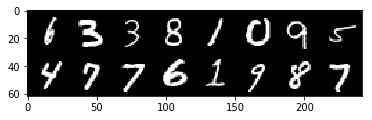

In [4]:
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
lib.imshow_grid(example_mini_batch_img[0:16,:,:])

In [ ]:
class Generator(torch.nn.Module):
    """
    Generator Class for GAN
    """
    def __init__(self, input_node_size, hidden_node_size=128, output_node_size=28*28):
        super(Generator, self).__init__()
        self.num_noise = num_noise
        self.network = torch.nn.Sequential(
            
            torch.nn.Linear(input_node_size, hidden_node_size),
            torch.nn.BatchNorm1d(num_features = hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, hidden_node_size),
            torch.nn.BatchNorm1d(num_features = hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, output_node_size),
            torch.nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.network(x).view((x.shape[0], 28, 28))

In [ ]:
class Discriminator(torch.nn.Module):
    """
    Discriminator Class for GAN
    """
    def __init__(self, input_node_size=28*28, hidden_node_size=128, output_node_size=1):
        super(Discriminator, self).__init__()
        
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_node_size, hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, output_node_size),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        return self.network(x).view(-1, 1)

Epoch 500
Real Image Probability: 50.287, Generated Image Probability: 50.041
(3, 92, 242)


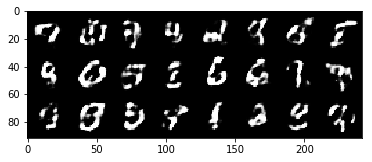

Epoch 1000
Real Image Probability: 49.982, Generated Image Probability: 49.855
(3, 92, 242)


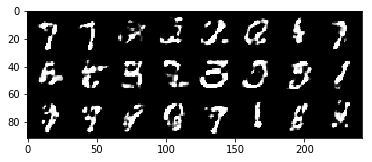

Epoch 1500
Real Image Probability: 50.146, Generated Image Probability: 50.032
(3, 92, 242)


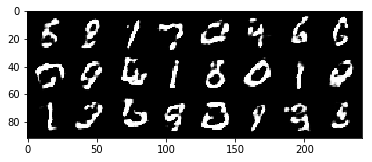

Epoch 2000
Real Image Probability: 49.874, Generated Image Probability: 49.855
(3, 92, 242)


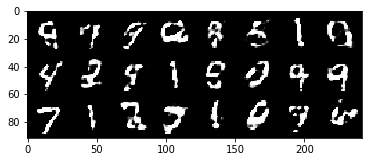

Epoch 2500
Real Image Probability: 49.321, Generated Image Probability: 49.238
(3, 92, 242)


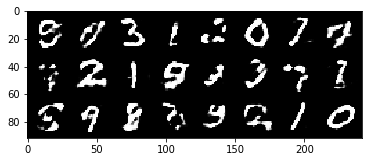

Epoch 3000
Real Image Probability: 50.479, Generated Image Probability: 50.381
(3, 92, 242)


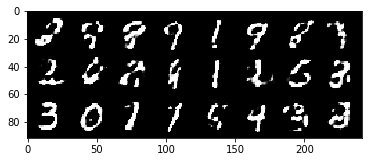

Epoch 3500
Real Image Probability: 49.764, Generated Image Probability: 49.760
(3, 92, 242)


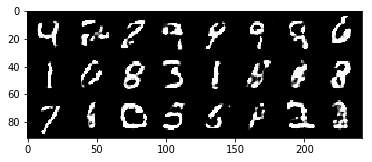

Epoch 4000
Real Image Probability: 50.114, Generated Image Probability: 50.023
(3, 92, 242)


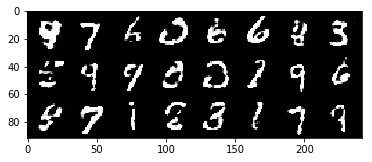

Epoch 4500
Real Image Probability: 50.225, Generated Image Probability: 50.143
(3, 92, 242)


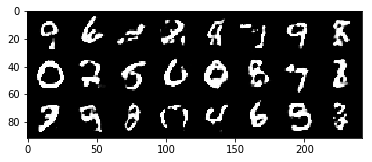

Epoch 5000
Real Image Probability: 50.185, Generated Image Probability: 50.100
(3, 92, 242)


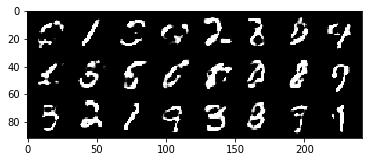

Epoch 5500
Real Image Probability: 50.199, Generated Image Probability: 50.123
(3, 92, 242)


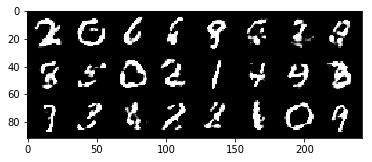

In [ ]:
epochs = 10000
gen = Generator(input_node_size=num_noise)
disc = Discriminator()
bceloss = torch.nn.BCELoss()

if torch.cuda.is_available():
    gen = gen.cuda()
    disc = disc.cuda()
    bceloss = bceloss.cuda()

lib.init_params(gen)
lib.init_params(disc)


gen_optim = torch.optim.RMSprop(gen.parameters(), lr=0.00005)
disc_optim = torch.optim.RMSprop(disc.parameters(), lr=0.00005)
'''
gen_optim = torch.optim.Adam(gen.parameters(), lr=0.001)
disc_optim = torch.optim.Adam(disc.parameters(), lr=0.001)
'''
for epoch in range(epochs):
    running_loss = 0.0
    disc.train()
    gen.train()
    
    for i, data in enumerate(train_data_loader):
        x, _ = data
        num_data = x.shape[0]
        noise = lib.sample_noise(num_data, num_noise)
        
        ones = torch.ones((num_data, 1), requires_grad=False)
        zeros = torch.zeros((num_data, 1), requires_grad=False)
        
        if torch.cuda.is_available():
            x = x.cuda()
            noise = noise.cuda()
            ones = ones.cuda()
            zeros = zeros.cuda()
        
        gen_img = gen(noise).view(num_data, -1).detach()
                    
        ### Discriminator
        disc_optim.zero_grad()
        p_real = disc(x.view(-1, 28*28))
        p_fake = disc(gen_img)
        
        #loss_d = bceloss(p_real, ones) + bceloss(p_fake, zeros)
        loss_d = -torch.mean(p_real) + torch.mean(p_fake)
        loss_d.backward()
        disc_optim.step()
        
        for params in disc.parameters():
            params.data.clamp_(-0.01, 0.01)
            #params = torch.clamp(params, -0.01, 0.01)
            
        if i % 5 == 0:
            ### Generator
            gen_optim.zero_grad()
            p_fake = disc(gen(lib.sample_noise(batch_size, num_noise)).view(-1, 28*28))

            #loss_g = bceloss(p_fake, ones)
            loss_g = -torch.mean(p_fake)
            loss_g.backward()
            gen_optim.step()

    if epoch % 500 == 499:
        disc.eval()
        gen.eval()
        
        p_real = p_gen = 0.0
        noise = lib.sample_noise(24, num_noise)
        if torch.cuda.is_available():
            noise = noise.cuda()
            
        for i, data in enumerate(test_data_loader):
            x, _ = data
            #num_data = x.shape[0]
            if torch.cuda.is_available():
                x = x.cuda()
                #y = y.cuda()
                
            with torch.autograd.no_grad():
                fake_img = gen(noise).view(-1, 28*28)
                p_real += disc(x.view(-1, 28*28)).mean()
                p_gen += disc(fake_img).mean()
                
        print("Epoch %d\nReal Image Probability: %.3f, Generated Image Probability: %.3f" % (epoch+1, p_real, p_gen))
        fake_img = gen(noise).view((-1, 1, 28, 28))
        lib.imshow_grid(fake_img)
        lib.imsave(fake_img, epoch)